# Lab Vision Sytems: Session 4

# Today:

### 1: Recurrent Neural Networks (RNNs)
### 2: Training your RNN in PyTorch

# 0. Some Comments

### - Encapsulation

Instead of writing all the code sequentially, encapsulate functionalities that will be reused:

In [1]:
import torch.nn as nn

In [3]:
class ConvBlock(nn.Module):
    """
    Encapuslation of a convolutional block (conv + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False):
        layers = []
        layers.append(nn.Conv2d(in_ch, out_ch, k_size))
        layers.append(nn.ReLU())
        if(pool):
            layers.append(nn.MaxUnpool2d(kernel_size=2))
        self.module = nn.Sequential(*layers)
    def forward(self, x):
        return(self.module(x))

class NetworkEncaps(nn.Module):
    """ 
    Neural network: cascade of convolutional blocks
    Good readibility, and good coding practice
    """
    def __init__(self):
        self.model = self.Sequential(
            ConvBlock(3, 16, 3, pool=False),
            ConvBlock(16, 32, 3, pool=True),
            ConvBlock(32, 64, 3, pool=False),
            ConvBlock(64, 128, 3, pool=True),
            ConvBlock(128, 256, 3, pool=False)
        )
    def forward(self, x):
        return self.model(x)

In [2]:
class NetworkEncaps(nn.Module):
    """ 
    Neural network: cascade layers. Poor readibility and not a good practice
    """
    def __init__(self):
        self.model = self.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Conv2d(128, 256, 3),
            nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)

### - Reusing code
  - Feel free to reuse you code across Lab Sessions.
  - You can make some library files (e.g., augmentations.py, visualizations.py, training_utils.py, ...) where you have your standard code, and you just simply call those files.
  - If you do this, please submit those files along with the notebook

# 1. Recurrent Neural Networks

# 2. Image Classification with RNNs

  ####  1. Split images row-wise into a sequence of 28 28-dim vectors
  ####  2. Embed 28-dim inputs into vector representation
  ####  3. Sequentially feed embeddings to RNN 
  ####  4. Classify RNN output with a fully-connected laye

<img src="./imgs/pipeline.png">

In [4]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

## Loading Data 

In [5]:
# Downloading and Loading Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=True)
 
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [6]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

## Model

#### **Important:** PyTorch includes nn.LSTM() and nn.LSTMCell(). These two are inherently different!

See https://pytorch.org/docs/stable/nn.html#recurrent-layers

In [7]:
class SequentialClassifier(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        if(mode == "learned"):
            self.learned_h = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
            self.learned_c = nn.Parameter(
                    torch.randn(num_layers, 1, hidden_dim).requires_grad_()
                )
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)
        # LSTM model
        self.lstm = nn.LSTM(
            input_size=emb_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True
        )
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels * n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        # embeddings = embeddings.view(b_size, n_channels*n_rows, n_cols)

        # feeding LSTM. Does everything for you
        lstm_out, (h_out, c_out) = self.lstm(embeddings, (h,c)) 
        
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [20]:
class SequentialClassifierWithCells(nn.Module):
    """ 
    Sequential classifier for images. Embedded image rows are fed to a RNN
    Same as above, but using LSTMCells instead of the LSTM object
    
    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode

        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)
        
        # LSTM model       
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        self.lstm = nn.ModuleList(lstms)
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)
        
        # iterating over sequence length
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
            
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h, c

## Training Code 

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

## Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# model = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=2, mode="zeros")
model = SequentialClassifierWithCells(input_dim=28, emb_dim=64, hidden_dim=128, num_layers=2, mode="zeros")
count_model_params(model)

234570

In [23]:
model = model.to(device)

In [24]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [25]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

Epoch 1 Iter 235: loss 0.28760. : 100%|██████████| 235/235 [00:07<00:00, 30.67it/s]


Epoch 1/10
    Train loss: 1.16271
    Valid loss: 2.30671
    Accuracy: 12.7%




Epoch 2 Iter 235: loss 0.11434. : 100%|██████████| 235/235 [00:07<00:00, 31.29it/s]


Epoch 2/10
    Train loss: 0.26761
    Valid loss: 0.34495
    Accuracy: 90.51%




Epoch 3 Iter 235: loss 0.25457. : 100%|██████████| 235/235 [00:07<00:00, 30.60it/s]


Epoch 3/10
    Train loss: 0.16999
    Valid loss: 0.19442
    Accuracy: 94.12%




Epoch 4 Iter 235: loss 0.21157. : 100%|██████████| 235/235 [00:07<00:00, 30.54it/s]


Epoch 4/10
    Train loss: 0.1317
    Valid loss: 0.13554
    Accuracy: 96.1%




Epoch 5 Iter 235: loss 0.05493. : 100%|██████████| 235/235 [00:07<00:00, 30.96it/s]


Epoch 5/10
    Train loss: 0.10765
    Valid loss: 0.13022
    Accuracy: 96.19%




Epoch 6 Iter 235: loss 0.10639. : 100%|██████████| 235/235 [00:07<00:00, 30.56it/s]


Epoch 6/10
    Train loss: 0.08076
    Valid loss: 0.10862
    Accuracy: 96.89999999999999%




Epoch 7 Iter 235: loss 0.04709. : 100%|██████████| 235/235 [00:07<00:00, 30.35it/s]


Epoch 7/10
    Train loss: 0.07447
    Valid loss: 0.08379
    Accuracy: 97.44%




Epoch 8 Iter 235: loss 0.03259. : 100%|██████████| 235/235 [00:07<00:00, 30.33it/s]


Epoch 8/10
    Train loss: 0.07157
    Valid loss: 0.08026
    Accuracy: 97.61999999999999%




Epoch 9 Iter 235: loss 0.06023. : 100%|██████████| 235/235 [00:07<00:00, 30.33it/s]


Epoch 9/10
    Train loss: 0.06769
    Valid loss: 0.08019
    Accuracy: 97.59%




Epoch 10 Iter 235: loss 0.10453. : 100%|██████████| 235/235 [00:07<00:00, 30.53it/s]

Epoch 10/10
    Train loss: 0.06484
    Valid loss: 0.07864
    Accuracy: 97.78%


Training completed


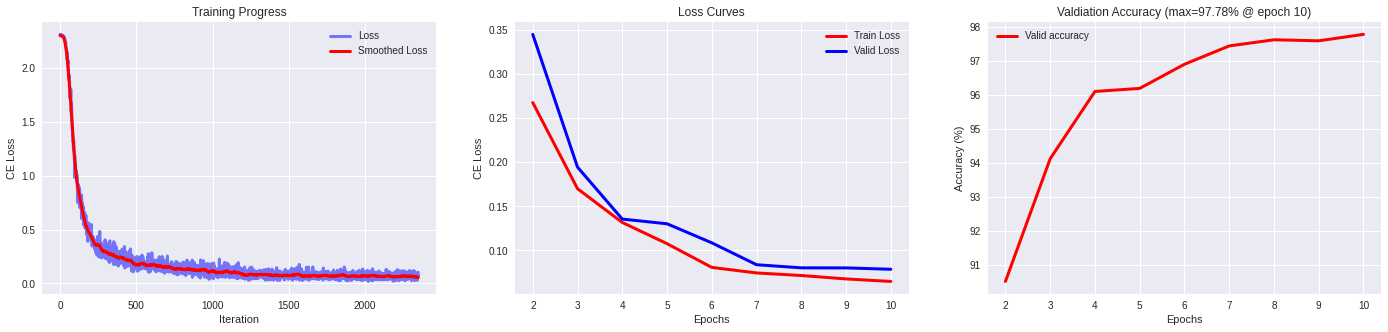

In [26]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

# Assignment 4

#### **Task 1**
 - Implement a Convolutional LSTM (ConvLSTM() and/or ConvLSTMCell()) from scratch

#### **Task 2**
 1. Perform "Action Recognition" on the KTH-Actions dataset:
    - https://www.csc.kth.se/cvap/actions/
    - https://github.com/tejaskhot/KTH-Dataset
    - Use spatial dimensionality of frames of 64x64
    - Split videos into subsequences of e.g. 20 frames. Treat each of these subsequences as independent.


2. Implement a model with the following structure:
    - Convolutional encoder
    - Recurrent module
    - Classifier (probably Conv + AvgPooling/Flattening + Linear)


 3. Train, evaluate, and compare the model with the following recurrent modules:
    - PyTorch LSTM model (using nn.LSTMCell)
    - PyTorch GRU model (using nn.GRUCell)
    - Your own ConvLSTM
    - **Note**: Different recurrent modules (e.g. LSTM vs ConvLSTM) might require slight changes in the encoder and classifier

#### **Extra Point**
  - Implement a 3D-CNN for action classification on the KTH-Actions dataset
  - Compare it with the RNN-based models

#### **Due Date**: Wednesday 4th January at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment4 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as html, any other .py files or images used.

### **Next Session: Friday 16th December**

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://colah.github.io/posts/2015-08-Understanding-LSTMs/

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  